In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

from sympy.solvers import solve
from sympy import Symbol
import numpy as np
import cmath
from scipy.optimize import linesearch
import scipy as sp
import scipy.optimize

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# BFGS
----------

In [2]:

epsilon = 10e-5

# class SetFunction()
#     def __init__(self):
#         self.fnc = 
def function3(x):
    x1 = x[0]
    x2 = x[1]
    return (-x1 + 1)**2 + 100*(-x1**2 + x2)**2

def objective3(x):
    x1 = x[0]
    x2 = x[1]
    a = -400*x1*(-x1**2 + x2) + 2*x1 - 2
    b = -200*x1**2 + 200*x2
    return [a,b]

######################################################

def function4(x):
    x1 = x[0]
    x2 = x[1]
    return x2**2 + (x1 + x2)**4

def objective4(x):
    x1 = x[0]
    x2 = x[1]
    a = 4*(x1 + x2)**3
    b = 2*x2 + 4*(x1 + x2)**3
    return [a,b]

######################################################

def function5a(x):
    x1 = x[0]
    x2 = x[1]
    return (x1-1)**2 + (x2-1)**2 + (x1**2 + x2**2 -0.25)**2

def objective5a(x):
    x1 = x[0]
    x2 = x[1]
    a = 4*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
    b = 4*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
    return [a,b]

######################################################

def function5b(x):
    x1 = x[0]
    x2 = x[1]
    return (x1 - 1)**2 + (x2 - 1)**2 + 10*(x1**2 + x2**2 - 0.25)**2

def objective5b(x):
    x1 = x[0]
    x2 = x[1]
    a = 40*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
    b = 40*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
    return [a,b]

######################################################

def function5c(x):
    x1 = x[0]
    x2 = x[1]
    return (x1 - 1)**2 + (x2 - 1)**2 + 100*(x1**2 + x2**2 - 0.25)**2

def objective5c(x):
    x1 = x[0]
    x2 = x[1]
    a = 400*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
    b = 400*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
    return [a,b]

######################################################
alpha_arr = []
def BFGSUpdate(xk, Bk, deriv1_xk, Q, function=None, objective=None):
    """
        xk:        Current value 
        Bk:        Approximated 2nd order matrix
        deriv1_xk: First order derivative of function f(xk)
        Q :        Q formed when we convert the function in standard form
                   Also equivallent to Hessian matrix, Computation is needed only once
                   No update is required
        
        pk (Search direction) = - inv(Bk).deriv1_xk 
    """
    pk = -1 * np.dot(np.linalg.inv(Bk),deriv1_xk)
    if len(Q)>=1:
        alpha = -1* np.dot(np.transpose(pk), deriv1_xk) / np.dot(np.dot(np.transpose(pk), Q), pk)
    else: # Implementing the line search algorithm
        a = linesearch.line_search_wolfe2(function,objective,xk,pk)
        if not a[0]:
            alpha = float(alpha_arr[len(alpha_arr)-1]/2)
        else:
            alpha_arr.append(a[0])
            alpha = alpha_arr[len(alpha_arr)-1]

    xk1 = xk + alpha*pk
    return xk1

def updateBk(step, deriv_1, xk, xk1, gradient_xk, Bk, numVariables):
    """
        step:             Step Num, int
        deriv_1           1st order derivative of the input function 
        xk:               previous solution
        xk1:              New Solution
        gradient_xk:      deriv_1 evaluated at xk1
        Bk:               Approximated 2nd order matrix
    """
    if numVariables == 3:
        gradient_xk1 =  np.array([eq.evalf(subs={x1:xk1[0], x2:xk1[1], x3:xk1[2]}) 
                                  for eq in deriv_1], dtype='float32')
    elif numVariables == 2:
        gradient_xk1 =  np.array([eq.evalf(subs={x1:xk1[0], x2:xk1[1]}) 
                                  for eq in deriv_1], dtype='float32')
    else:
        raise ValueError('Num Features doesnt match the handled condition')
        
#     print ('Gradient at xk%s: '%str(step), gradient_xk1)
    Sk = xk1 - xk
    Sk = np.array(Sk).reshape(len(Sk), 1)
#     print ('Sk at xk%s: %s \n'%(str(step), str(Sk.shape)), Sk)
    Yk = gradient_xk1 - gradient_xk
    Yk = np.array(Yk).reshape(len(Yk), 1)
#     print ('Yk at xk%s: %s \n'%(str(step), str(Yk.shape)), Yk)
    numerator = np.dot(np.dot(Bk,Sk),np.transpose(np.dot(Bk,Sk)))
#     print ('numerator at xk%s: \n'%str(step), numerator)
    denominator = np.dot(np.transpose(Sk),np.dot(Bk,Sk))
#     print ('denominator at xk%s: \n'%str(step), denominator)
    RHS = np.dot(Yk, np.transpose(Yk))/np.dot(np.transpose(Yk), Yk)
#     print ('RHS at xk%s: \n'%str(step), RHS)
    Bk1 = Bk - (numerator/denominator) + RHS
#     print ('BkBkBkBkBkBkBkBkBkBkBkBkBk\n', Bk1)
    return Bk1

In [14]:
def iterateNonQuadratic(f, xk, deriv_1, Bk, function, objective, numFeature, numSteps, should_print):
    fx_arr = []
    gradientNorm_arr = []
    alpha_arr = []
    for step in range(numSteps):
#         print('stepstepstep ', step)
        # Solve for gradient
        fx = f.evalf(subs={x1:xk[0], x2:xk[1]})
        fx_arr.append(fx)
        gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1]}) for eq in deriv_1], dtype='float32')
        gradientNorm = np.linalg.norm(gradient_xk)
        gradientNorm_arr.append(np.linalg.norm(gradientNorm))
        
        if should_print:
            if (step+1)%should_print == 0:
                print('')
                print ('##########################################################')
                print ('Function F at x: f(x) ', fx)
                print ('Gradient at xk%s is: '%str(step), gradient_xk)
                print ("####### Gradient Norm: ", gradientNorm)
                print('The updated Value Bk%s is \n'%(step+1), Bk)
                print('The updated Value xk%s is \n'%(step+1), xk)
                
                
        if np.sum((gradientNorm/(1+np.abs(gradient_xk))) <= epsilon) == len(gradient_xk) or (step == 1000):
            print('The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)')
            break

        xk1 = BFGSUpdate(xk=xk, Bk=Bk, deriv1_xk=gradient_xk, 
                         Q=[], function=function, objective=objective)
        Bk1 = updateBk(step+1, deriv_1, xk, xk1, gradient_xk, Bk, numVariables=numFeature)
#
        xk = xk1
        Bk = Bk1
    return fx_arr, gradientNorm_arr


def iterateQuadratic(f, xk, deriv_1, Q, Bk, numFeatures, numSteps, should_print):
    fx_arr = []
    gradientNorm_arr = []
    for step in range(numSteps):
        if numFeatures == 3:
            fx = f.evalf(subs={x1:xk[0], x2:xk[1], x3:xk[2]})
            gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1], x3:xk[2]}) for eq in deriv_1], 
                                   dtype='float32')
        elif numFeatures == 2:
            fx = f.evalf(subs={x1:xk[0], x2:xk[1]})
            gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1]}) for eq in deriv_1], 
                                   dtype='float32')
        else:
            raise ValueError('Num Features doesnt match the hadled condition')
        
        fx_arr.append(fx)
        gradientNorm = np.linalg.norm(gradient_xk)
        gradientNorm_arr.append(gradientNorm)
        
        if should_print:
            if (step+1)%should_print == 0:
                print('')
                print ('##########################################################')
                print ('Function F at x: f(x) ', fx)
                print ('Gradient at xk%s is: '%str(step), gradient_xk)
                print ("####### Gradient Norm: ", gradientNorm)
                print('The updated Value Bk%s is \n'%(step+1), Bk)
                print('The updated Value xk%s is \n'%(step+1), xk)
                
        if np.sum((gradientNorm/(1+np.abs(gradient_xk))) <= epsilon) == len(gradient_xk) or (step == 1000):
            print('The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)')
            break 
                
#         print ('Gradient at xk%s is: '%str(step), gradient_xk)
#         gradientNorm = np.linalg.norm(gradient_xk)
#         print ("####### Gradient Norm: ", gradientNorm)
#         if gradientNorm == 0:
#             break
            
#         print ('xk at step %s: \n'%str(step), xk)
        xk1 = BFGSUpdate(xk=xk, Bk=Bk, deriv1_xk=gradient_xk, Q=Q)
#         print ('xk1 at step %s: \n'%str(step), xk1)
        
        Bk1 = updateBk(step+1, deriv_1, xk, xk1, gradient_xk, Bk, numVariables=numFeatures)

        # Parameter UPdate
        xk = xk1
        Bk = Bk1

    return fx_arr, gradientNorm_arr


def plot(x_arr, rows=1, columns=2, figsize=(10, 3)):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='w', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    for no, arrVal in enumerate(x_arr):
        axs[no].plot(np.arange(len(arrVal)), arrVal)
        if no == 0:
            axs[no].set_xlabel('num of Iteration')
            axs[no].set_ylabel('Function f(x) at step')
            axs[no].set_title('Function Vs Num Iteration')
        else:
            axs[no].set_xlabel('num of Iteration')
            axs[no].set_ylabel('Gradient Norm at step')
            axs[no].set_title('Gradient Norm Vs Num Iteration')

# Solution d(1)

First order Derivative:  [2*x1 2*x2 2*x3]

##########################################################
Function F at x: f(x)  3.00000000000000
Gradient at xk0 is:  [ 2.  2.  2.]
####### Gradient Norm:  3.4641
The updated Value Bk1 is 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
The updated Value xk1 is 
 [1 1 1]

##########################################################
Function F at x: f(x)  0.e-125
Gradient at xk1 is:  [ 0.  0.  0.]
####### Gradient Norm:  0.0
The updated Value Bk2 is 
 [[  1.00000001e+00   9.93410748e-09   9.93410748e-09]
 [  9.93410748e-09   1.00000001e+00   9.93410748e-09]
 [  9.93410748e-09   9.93410748e-09   1.00000001e+00]]
The updated Value xk2 is 
 [ 0.  0.  0.]
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


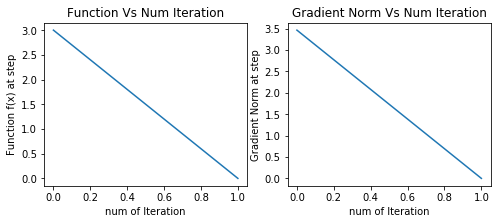

In [5]:
x1 = Symbol('x1')
x2 = Symbol('x2')
x3 = Symbol('x3')

f = pow(x1,2) + pow(x2,2) + pow(x3,2)
deriv_f_x1 = f.diff(x1)
deriv_f_x2 = f.diff(x2)
deriv_f_x3 = f.diff(x3)

f = pow(x1,2) + pow(x2,2) + pow(x3,2)
deriv_1 = np.array([f.diff(x1), f.diff(x2), f.diff(x3)])
print ('First order Derivative: ', deriv_1)
Q = np.array([[2,0,0],[0,2,0],[0,0,2]])  # Q is obtained by converting the funciton into quadratic form, which is equivallent to 2nd order derivative in all our case

# Initialize BK
Bk = np.eye(3)

# Initialize Xk
xk = np.array([1,1,1])

fx_array, gradientNorm_arr = iterateQuadratic(f, xk, deriv_1, Q, Bk, numFeatures=3, numSteps=10, should_print=1)

plot([fx_array, gradientNorm_arr])

# Solution d(2)


##########################################################
Function F at x: f(x)  0.e-125
Gradient at xk0 is:  [ 0. -2.]
####### Gradient Norm:  2.0
The updated Value Bk1 is 
 [[ 1.  0.]
 [ 0.  1.]]
The updated Value xk1 is 
 [ 0.  0.]

##########################################################
Function F at x: f(x)  -0.500000000000000
Gradient at xk1 is:  [-1.  0.]
####### Gradient Norm:  1.0
The updated Value Bk2 is 
 [[ 1.2        -0.40000001]
 [-0.40000001  0.80000001]]
The updated Value xk2 is 
 [ 0.   0.5]

##########################################################
Function F at x: f(x)  -1.00000000000000
Gradient at xk2 is:  [ 0.  0.]
####### Gradient Norm:  0.0
The updated Value Bk3 is 
 [[ 1.2        -0.40000001]
 [-0.40000001  0.80000001]]
The updated Value xk3 is 
 [ 1.  1.]
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


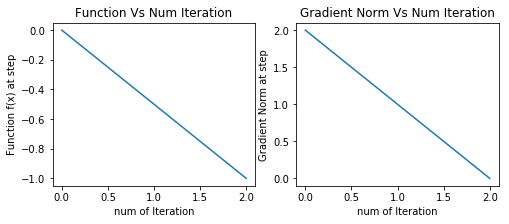

In [6]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = pow(x1,2) + 2*pow(x2,2) - 2*x1*x2 - 2*x2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]], dtype=float)
# print ('Q: \n', Q)

# Initialize BK
Bk = np.eye(2)

# Initialize Xk
xk = np.array([0,0], dtype=float)

fx_array, gradientNorm_arr = iterateQuadratic(f, xk, deriv_1, Q, Bk, numFeatures=2, numSteps=10, should_print=1)

plot([fx_array, gradientNorm_arr])

# Solution d(3)

-400*x1*(-x1**2 + x2) + 2*x1 - 2
-200*x1**2 + 200*x2

##########################################################
Function F at x: f(x)  2.64748296980024
Gradient at xk3 is:  [-12.28486729  -7.88793039]
####### Gradient Norm:  14.5992
The updated Value Bk4 is 
 [[ 1.33488409  0.92504225]
 [ 0.92504225  0.6608065 ]]
The updated Value xk4 is 
 [-0.57858619  0.29532233]

##########################################################
Function F at x: f(x)  0.00747308857183992
Gradient at xk7 is:  [-0.04275709 -0.07113989]
####### Gradient Norm:  0.0830003
The updated Value Bk8 is 
 [[ 0.88227897 -0.18516663]
 [-0.18516663  0.7245782 ]]
The updated Value xk8 is 
 [ 0.91362618  0.8343571 ]

##########################################################
Function F at x: f(x)  5.96470864698886e-5
Gradient at xk11 is:  [-0.02163053  0.00311776]
####### Gradient Norm:  0.0218541
The updated Value Bk12 is 
 [[ 0.80516548 -0.40793589]
 [-0.40793589  0.20826723]]
The updated Value xk12 is 
 [ 0.99227842  0.

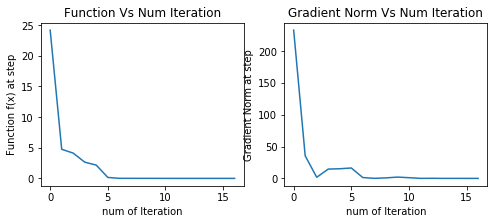

In [7]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (-x1 + 1)**2 + 100*(-x1**2 + x2)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Bk = np.eye(2)
# Initialize Xk
xk = np.array([-1.2,1], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, Bk,
                                                 function3, objective3,
                                                 numFeature=2, numSteps=20, should_print=4)  
# (f, xk, deriv_1, Bk, function, objective, numFeature, numSteps, should_print)
plot([fx_array, gradientNorm_arr])

# Solution d(4)

4*(x1 + x2)**3
2*x2 + 4*(x1 + x2)**3

##########################################################
Function F at x: f(x)  0.0276118639223384
Gradient at xk3 is:  [ 0.12774411 -0.13667654]
####### Gradient Norm:  0.18708
The updated Value Bk4 is 
 [[ 0.49693201  0.38693487]
 [ 0.38693487  1.22488277]]
The updated Value xk4 is 
 [ 0.44947882 -0.13221032]

##########################################################
Function F at x: f(x)  1.54924232495337e-5
Gradient at xk7 is:  [ 0.00098668  0.00068716]
####### Gradient Norm:  0.00120239
The updated Value Bk8 is 
 [[ 0.69590559  0.46834689]
 [ 0.46834689  1.30579948]]
The updated Value xk8 is 
 [ 0.06286492 -0.00014976]

##########################################################
Function F at x: f(x)  4.00439345365491e-6
Gradient at xk11 is:  [ 0.00035789  0.00025552]
####### Gradient Norm:  0.000439743
The updated Value Bk12 is 
 [[ 0.53809028  0.04186991]
 [ 0.04186991  1.00159736]]
The updated Value xk12 is 
 [  4.47775023e-02  -5.1186868

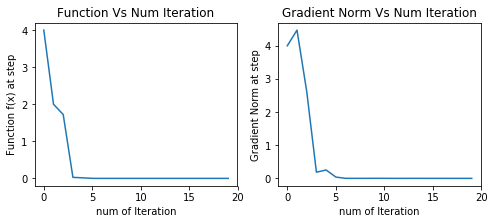

In [8]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = x2**2 + (x1 + x2)**4
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Bk = np.eye(2)
# Initialize Xk
xk = np.array([2,-2], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, Bk,
                                                 function4, objective4,
                                                 numFeature=2, numSteps=20, should_print=4)  
plot([fx_array, gradientNorm_arr])

# Solution d(5)

## a)

4*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
4*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


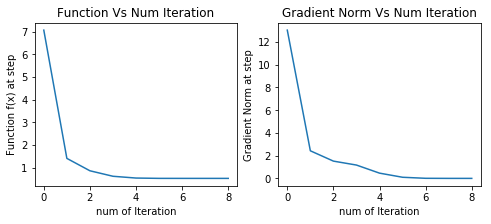

In [9]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + (x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Bk = np.eye(2)
# Initialize Xk
xk = np.array([1,-1], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, Bk, 
                                                 function5a, objective5a,
                                                 numFeature=2, numSteps=300, should_print=50)  
plot([fx_array, gradientNorm_arr])

## b)

40*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
40*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2

##########################################################
Function F at x: f(x)  2.16259430671578
Gradient at xk1 is:  [-3.31428742 -0.3923268 ]
####### Gradient Norm:  3.33743
The updated Value Bk2 is 
 [[  1.02575946e+00  -7.67016512e-04]
 [ -7.67016512e-04   9.74240514e-01]]
The updated Value xk2 is 
 [-0.34405736  0.42086064]

##########################################################
Function F at x: f(x)  0.789371742310823
Gradient at xk3 is:  [-0.69937366 -0.33040866]
####### Gradient Norm:  0.773494
The updated Value Bk4 is 
 [[ 0.75423934  0.19976675]
 [ 0.19976675  0.8383851 ]]
The updated Value xk4 is 
 [ 0.33495529  0.42997625]

##########################################################
Function F at x: f(x)  0.770524009722895
Gradient at xk5 is:  [ 0.14881417  0.25270054]
####### Gradient Norm:  0.293263
The updated Value Bk6 is 
 [[ 1.14359698  0.82088075]
 [ 0.82088075  1.18064065]]
The upd

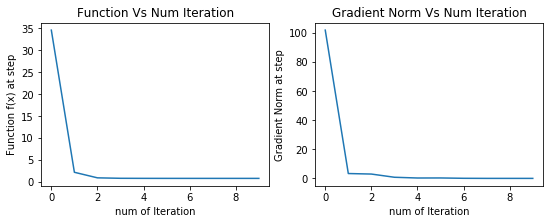

In [12]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + 10*(x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Bk = np.eye(2)
# Initialize Xk
xk = np.array([1,-1], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, Bk, 
                                                 function5b, objective5b,
                                                 numFeature=2, numSteps=10, should_print=2)  
plot([fx_array, gradientNorm_arr])

## c)

400*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
400*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


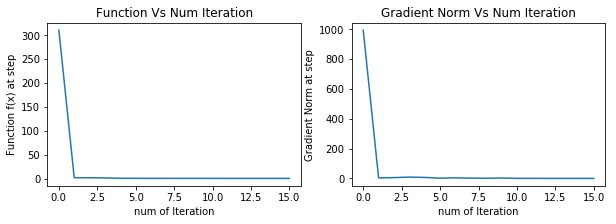

In [15]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + 100*(x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Bk = np.eye(2)
# Initialize Xk
xk = np.array([1,-1], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, Bk, 
                                                 function5c, objective5c,
                                                 numFeature=2, numSteps=300, should_print=50)  
plot([fx_array, gradientNorm_arr])